In [2]:
import chess
board = chess.Board()
print(board.unicode())

♜ ♞ ♝ ♛ ♚ ♝ ♞ ♜
♟ ♟ ♟ ♟ ♟ ♟ ♟ ♟
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
♙ ♙ ♙ ♙ ♙ ♙ ♙ ♙
♖ ♘ ♗ ♕ ♔ ♗ ♘ ♖


In [3]:
def print_bitboard(bitboard):
    
    # for each row
    for i in range(8):
        
        # print bitboard of 1s/0s (we have to mirror the bitboard)
        if i == 0:
            print(format(bitboard, "064b")[8*(i+1)-1::-1])
        else:
            print(format(bitboard, "064b")[8*(i+1)-1:8*i-1:-1])

# bitboard of pawns
print_bitboard(board.pawns)

00000000
11111111
00000000
00000000
00000000
00000000
11111111
00000000


In [4]:
print_bitboard(board.bishops)


00100100
00000000
00000000
00000000
00000000
00000000
00000000
00100100


In [5]:
import numpy as np

def encode_valid_moves(board):
    
    valid_moves_dict = {}
    
    # for each valid move
    for move in board.legal_moves:
        
        # compute index based on starting square and target square
        index = 64 * (move.from_square) + (move.to_square)
        valid_moves_dict[index] = move
    
    return valid_moves_dict

valid_moves_dict = encode_valid_moves(board)
valid_moves_dict
def mask_and_valid_moves(board):

    mask = np.zeros((64, 64))
    valid_moves_dict = {}
    
    # for each valid move
    for move in board.legal_moves:
        
        # mask is a matrix
        mask[move.from_square, move.to_square] = 1
        
        # compute index based on starting square and target square
        index = 64 * (move.from_square) + (move.to_square)
        
        valid_moves_dict[index] = move
    
    return mask, valid_moves_dict

mask, valid_moves_dict = mask_and_valid_moves(board)
mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# This is our final mask layer
class MaskLayer(nn.Module):

    def __init__(self):
        super(MaskLayer, self).__init__()
    
    # mask is made of 0s/1s so it will just set to 0 any invalid move
    def forward(self, x, mask):
        return torch.mul(x, mask)

In [8]:
class DQN(nn.Module):

    def __init__(self):
        
        super(DQN, self).__init__()
        
        # input size = 8 (rows) x 8 (cols) x 16 (bitboards)
        # - 6 bitboards for white pieces
        # - 6 bitboards for black pieces
        # - 1 for empty squares
        # - 1 for castling rights
        # - 1 for en passant
        # - 1 for player
        
        # first convolutional layer 8x8x16 => 8x8x32
        self.conv1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # second convolutional layer 8x8x32 => 8x8x64 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # third convolutional layer 8x8x64 => 8x8x128 
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # first fully connected layer 8192 => 8192
        self.fc1 = nn.Linear(128*64, 128*64)
        
        # second fully connected layer 8192 => 4096
        self.fc2 = nn.Linear(128*64, 64*64)
        
        # mask is made of 0s/1s so it will just set to 0 any invalid move 4096 => 4096
        self.mask = MaskLayer()

    def forward(self, x, mask=None, debug=False):
        
        # conv1 + bn1 with activation function ReLU
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        
        # conv2 + bn2 with activation function ReLU
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        
        # conv3 + bn3 with activation function ReLU
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        
        # flatten will transform data structure from 3D 8x8x128 to 1D 8192
        x = nn.Flatten()(x)
        
        # fully connected with activation function ReLU
        x = nn.functional.relu(self.fc1(x))
        
        # fully connected WITHOUT ReLU (we want to keep negative values for our output layer)
        x = self.fc2(x)
        
        # if we have a mask we apply it to set to 0 all invalid moves
        if mask is not None:
            x = self.mask(x, mask)
            
        return x

In [15]:
stockfish = chess.engine.SimpleEngine.popen_uci(r"C:\Users\ual-laptop\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe")


In [17]:
import chess
import chess.engine
import random

# for now our agent choose a random move
def agent_choose_move(board):
    return random.choice(list(board.legal_moves))

# Create a chess board
board = chess.Board()

# Create a stockfish engine instance
stockfish = chess.engine.SimpleEngine.popen_uci(r"C:\Users\ual-laptop\Downloads\stockfish-windows-x86-64-avx2\stockfish\stockfish-windows-x86-64-avx2.exe")

# Analyse starting board with stockfish
board_score_before = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
    ['score'].relative.score(mate_score=10000)

# Agent choose move
move = agent_choose_move(board)
board.push(move)

# Make random move for black
board.push(random.choice(list(board.legal_moves)))

# Analyse final board with stockfish
board_score_after = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
    ['score'].relative.score(mate_score=10000)

# Divide by 100 to transform to centipawn to pawn score and subtract 0.01 to penalize the agent for each move. 
# We want to win as fast as possible ;)
reward = board_score_after/100 - board_score_before/100 - 0.01


In [23]:
reward


-0.76

In [24]:
epsilon = 1
epsilon_decay = 0.995
epsilon_min = 0.01

# choose random with probability epsilon
if random.uniform(0, 1) <= epsilon:
    move = random.choice(list(board.legal_moves))
    
# choose best move with probability 1 - epsilon
else:
    move = agent_choose_move(board)

# reduce exploration rate after each step
epsilon = max(epsilon * epsilon_decay, epsilon_min)
epsilon

0.995

In [26]:
import os

class ChessAgent:

    # Constructor
    def __init__(self, input_model_path=None):

        # Exploration parameters
        self.epsilon = 1
        self.epsilon_decay = 0.99
        self.epsilon_min = 0.01

        # Training parameters
        self.gamma = 0.5 # tells the agent whether to prefer long term rewards or immediate rewards. 0 = greedy, 1 = long term
        self.learning_rate = 1e-03 # how fast the network updates its weights
        self.MEMORY_SIZE = 512 # how many steps/moves/samples to store. It is used for training (experience replay) 
        self.MAX_PRIORITY = 1e+06 # max priority for a sample in memory. The higher the priority, the more likely the sample will be included in training
        self.memory = [] # memory data structure
        self.batch_size = 16 # how many sample to include in a training step        
        
        self.policy_net = DQN()
        
        # Load trained model if exists
        if input_model_path is not None and os.path.exists(input_model_path):
            self.policy_net.load_state_dict(torch.load(input_model_path))    

        # We use mean squared error as our loss function
        self.loss_function = nn.MSELoss()
        
        # Adam optimizer provides adaptive learning rate and a momentum-based approach that can help the neural network 
        # learn faster and converge more quickly towards the optimal set of parameters that minimize the cost or loss function
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)

    
    # Convert board into a 3D np.array of 16 bitboards
    def convert_state(self, board):
        
        # dictionary to store bitboards
        piece_bitboards = {}
        
        # for each color (white, black)
        for color in chess.COLORS:
            
            # for each piece type (pawn, bishop, knigh, rook, queen, kinb)
            for piece_type in chess.PIECE_TYPES:
                v = board.pieces_mask(piece_type, color)
                symbol = chess.piece_symbol(piece_type)
                i = symbol.upper() if color else symbol
                piece_bitboards[i] = v

        # empty bitboard
        piece_bitboards['-'] = board.occupied ^ 2 ** 64 - 1
        
        # player bitboard (full 1s if player is white, full 0s otherwise)
        player = 2 ** 64 - 1 if board.turn else 0

        # castling_rights bitboard
        castling_rights = board.castling_rights

        # en passant bitboard
        en_passant = 0
        ep = board.ep_square
        if ep is not None:
            en_passant |= (1 << ep)

        # bitboards (16) = 12 for pieces, 1 for empty squares, 1 for player, 1 for castling rights, 1 for en passant
        bitboards = [b for b in piece_bitboards.values()] + [player] + [castling_rights] + [en_passant]

        # for each bitboard transform integet into a matrix of 1s and 0s
        # reshape in 3D format (16 x 8 x 8)
        bitarray = np.array([
            np.array([(bitboard >> i & 1) for i in range(64)])
            for bitboard in bitboards
        ]).reshape((16, 8, 8))

        return bitarray

    
    # get the move index out of the 4096 possible moves, as explained before
    def get_move_index(self, move):
        index = 64 * (move.from_square) + (move.to_square)
        return index

    
    # returns mask of valid moves (out of 4096) + the dictionary with the valid moves and their indexes
    def mask_and_valid_moves(self, board):

        mask = np.zeros((64, 64))
        valid_moves_dict = {}
        
        for move in board.legal_moves:
            mask[move.from_square, move.to_square] = 1
            valid_moves_dict[self.get_move_index(move)] = move
        
        # mask is flatten and returned as a PyTorch tensor
        # a tensor is just a vector optimized for derivatives computation, used in PyTorch neural nets
        return torch.from_numpy(mask.flatten()), valid_moves_dict

    
    # insert a step/move/sample into memory to be used in training as experience replay
    def remember(self, priority, state, action, reward, next_state, done, valid_moves, next_valid_moves):

        # if memory is full, we delete the least priority element
        if len(self.memory) >= self.MEMORY_SIZE:
            
            min_value = self.MAX_PRIORITY
            min_index = 0
            
            for i,n in enumerate(self.memory):
                
                # priority is stored in the first position of the tuple
                if n[0] < min_value:
                    min_value = n[0]
                    min_index = i
            
            del self.memory[min_index]

        self.memory.append((priority, state, action, reward, next_state, done, valid_moves, next_valid_moves))

    
    # Take a board as input and return a valid move defined as tuple (start square, end square)
    def select_action(self, board, best_move):

        # convert board into the 16 bitboards
        bit_state = self.convert_state(board)
        
        # get valid moves
        valid_moves_tensor, valid_move_dict = self.mask_and_valid_moves(board)
        
        # with probability epsilon = Explore
        if random.uniform(0, 1) <= self.epsilon:
            
            r = random.uniform(0, 1)
            
            # inside exploration with probability 10% choose best move (as computed by stockfish)
            if r <= 0.1:
                chosen_move = best_move
            
            # with probability 90% choose a random move
            else:
                chosen_move = random.choice(list(valid_move_dict.values()))
        
        # with probability 1 - epsilon = Exploit
        else:
            
            # during inference we don't need to compute gradients
            with torch.no_grad():
                
                # transform our 16 bitboards in a tensor of shape 1 x 16 x 8 x 8
                tensor = torch.from_numpy(bit_state).float().unsqueeze(0)
                
                # predict rewards for each valid move in the current state. valid_moves_tensor is the mask!
                policy_values = self.policy_net(tensor, valid_moves_tensor)
                
                # take the move index with the highest predicted reward
                chosen_move_index = int(policy_values.max(1)[1].view(1,1))
                
                # if move is valid:
                if chosen_move_index in valid_move_dict:
                    chosen_move = valid_move_dict[chosen_move_index]
                    
                # if move is NOT valid, choose random move
                # this can happen if all valid moves have predicted values 0 or negative
                else:
                    chosen_move = random.choice(list(board.legal_moves))

        return self.get_move_index(chosen_move), chosen_move, bit_state, valid_moves_tensor

    
    # Decay epsilon (exploration rate)
    def adaptiveEGreedy(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

        
    # Save trained model
    def save_model(self, path):
        torch.save(self.policy_net.state_dict(), path)

In [28]:
def learn_experience_replay(self, debug=False):
    
    batch_size = self.batch_size

    # if memory does not have enough sample to fill a batch, return
    if len(self.memory) < batch_size:
        return

    # get priorities from the first element in the memory samples tuple
    priorities = [x[0] for x in self.memory]
    
    # the higher the priority, the more probable the sample will be included in the batch training
    priorities_tot = np.sum(priorities)
    weights = priorities / priorities_tot

    # extract samples for the batch training
    minibatch_indexes = np.random.choice(range(len(self.memory)), size=batch_size, replace=False, p=weights)
    minibatch = [self.memory[x] for x in minibatch_indexes]

    # unpack the tuples in the batch into different lists, to be converted into tensors
    state_list = []
    state_valid_moves = []
    action_list = []
    reward_list = []
    next_state_list = []
    next_state_valid_moves = []
    done_list = []

    for priority, bit_state, action, reward, next_bit_state, done, state_valid_move, next_state_valid_move in minibatch:

        # bit state is the 16 bitboards of the state before the move
        state_list.append(bit_state)
        
        # state_valid_moves is a tensor containing the indexes of valid moves (out of 4096)
        state_valid_moves.append(state_valid_move.unsqueeze(0))
        
        # action is the index of the chosen move (out of 4096)
        action_list.append([action])
        
        # reward is the reward obtained by making the chosen move
        reward_list.append(reward)
        
        # done indicates if the game ended after making the chosen move
        done_list.append(done)

        if not done:
            
            # next_bit_state is the 16 bitboards of the state after the move
            next_state_list.append(next_bit_state)
            
            # next_state_valid_moves is a tensor containing the indexes of valid moves (out of 4096)
            next_state_valid_moves.append(next_state_valid_move.unsqueeze(0))

    # state_valid_moves and next_state_valid_moves are already tensors, we just need to concat them
    state_valid_move_tensor = torch.cat(state_valid_moves, 0)
    next_state_valid_move_tensor = torch.cat(next_state_valid_moves, 0)

    # convert all lists to tensors
    state_tensor = torch.from_numpy(np.array(state_list)).float()
    action_list_tensor = torch.from_numpy(np.array(action_list, dtype=np.int64))
    reward_list_tensor = torch.from_numpy(np.array(reward_list)).float()
    next_state_tensor = torch.from_numpy(np.array(next_state_list)).float()
    
    # create a tensor with 
    bool_array = np.array([not x for x in done_list])
    not_done_mask = torch.tensor(bool_array, dtype=torch.bool)
    
    # compute the expected rewards for each valid move
    policy_action_values = self.policy_net(state_tensor, state_valid_move_tensor)
    
    # get only the expected reward for the chosen move (to calculate loss against the actual reward)
    policy_action_values = policy_action_values.gather(1, action_list_tensor)
    
    # target values are what we want the network to predict (our actual values in the loss function)
    # target values = reward + max_reward_in_next_state * gamma
    # gamma is the discount factor and tells the agent whether to prefer long term rewards or immediate rewards. 0 = greedy, 1 = long term 
    max_reward_in_next_state = torch.zeros(batch_size, dtype=torch.double)
    
    with torch.no_grad():
        
        # if the state is final (done = True, not_done_mask = False) the max_reward_in_next_state stays 0 
        max_reward_in_next_state[not_done_mask] = self.policy_net(next_state_tensor, next_state_valid_move_tensor).max(1)[0]
    
    target_action_values = (max_reward_in_next_state * self.gamma) + reward_list_tensor
    target_action_values = target_action_values.unsqueeze(1)
    
    # loss is computed between expected values (predicted) and target values (actual)
    loss = self.loss_function(policy_action_values, target_action_values)

    # Update priorities of samples in memory based on size of error (higher error = higher priority)
    for i in range(batch_size):
        
        predicted_value = policy_action_values[i]
        target_value = target_action_values[i]
        
        # priority = mean squared error
        priority = F.mse_loss(predicted_value, target_value, reduction='mean').detach().numpy()
        
        # change priority of sample in memory
        sample = list(self.memory[minibatch_indexes[i]])
        sample[0] = priority
        self.memory[minibatch_indexes[i]] = tuple(sample)

    # clear gradients of all parameters from the previous training step
    self.optimizer.zero_grad()
    
    # calculate the new gradients of the loss with respect to all the model parameters by traversing the network backwards
    loss.backward()
    
    # adjust model parameters (weights, biases) according to computed gradients and learning rate
    self.optimizer.step()
    
    if debug:
        print("state_tensor shape", state_tensor.shape)
        print("\naction_list_tensor shape", action_list_tensor.shape)
        print("\naction_list_tensor (chosen move out of 4096)", action_list_tensor)
        print("\npolicy_action_values (expected reward of chosen move)", policy_action_values)
        print("\nnot_done_mask", not_done_mask)
        print("\ntarget_action_values", target_action_values)
        print("\nreward_list_tensor", reward_list_tensor)
        print("\nloss:", loss)

    # return loss so that we can plot loss by training step
    return float(loss)

# add this new method to our ChessAgent class
setattr(ChessAgent, "learn_experience_replay", learn_experience_replay)

In [30]:
# generate a random training sample
def generate_random_sample(agent, stockfish, board):
    
    # set a standard priority
    priority = 1
    
    # convert board in 16 bitboards
    state = agent.convert_state(board)
    
    # get valid moves tensor
    valid_moves, _ = agent.mask_and_valid_moves(board)
    
    # choose random move and compute its index (out of 4096)
    random_move = random.choice(list(board.legal_moves))
    action = agent.get_move_index(random_move)
    
    # make random move for white and black and compute reward
    board_score_before = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
        ['score'].relative.score(mate_score=10000)
    
    board.push(random_move)
    board.push(random.choice(list(board.legal_moves)))
    
    board_score_after = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))\
        ['score'].relative.score(mate_score=10000)
    
    # divide by 100 to convert from centipawns to pawns score
    reward = board_score_after / 100 - board_score_before / 100 - 0.01
    
    # convert board in 16 bitboard
    next_state = agent.convert_state(board)
    
    # if board.result() == * the game is not finished
    done = board.result() != '*'
    
    # get valid moves tensor
    next_valid_moves, _ = agent.mask_and_valid_moves(board)
    
    # undo white and black moves
    board.pop()
    board.pop()
    
    # store in agent memory
    agent.remember(priority, state, action, reward, next_state, done, valid_moves, next_valid_moves)

In [32]:
board = chess.Board()

# Create an agent
agent = ChessAgent()

for i in range(16):
    generate_random_sample(agent, stockfish, board)

len(agent.memory)

16

In [33]:
agent.learn_experience_replay(debug=True)


state_tensor shape torch.Size([16, 16, 8, 8])

action_list_tensor shape torch.Size([16, 1])

action_list_tensor (chosen move out of 4096) tensor([[658],
        [593],
        [407],
        [788],
        [405],
        [407],
        [853],
        [593],
        [593],
        [658],
        [853],
        [983],
        [407],
        [991],
        [918],
        [658]])

policy_action_values (expected reward of chosen move) tensor([[-0.1383],
        [-0.0715],
        [ 0.2278],
        [ 0.1805],
        [-0.0629],
        [ 0.2278],
        [ 0.2189],
        [-0.0715],
        [-0.0715],
        [-0.1383],
        [ 0.2189],
        [-0.0853],
        [ 0.2278],
        [ 0.0290],
        [ 0.2488],
        [-0.1383]], dtype=torch.float64, grad_fn=<GatherBackward0>)

not_done_mask tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])

target_action_values tensor([[-0.0468],
        [ 0.2487],
        [-0.3048],
      

0.092446422040018

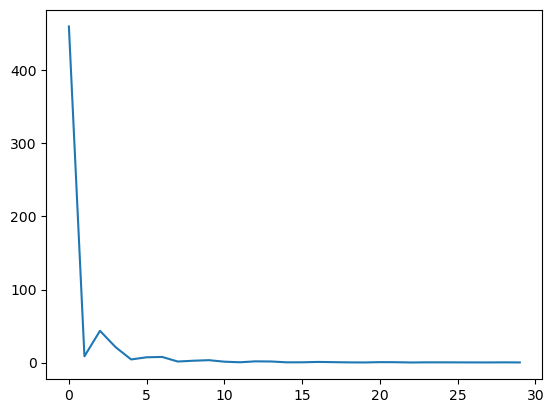

In [34]:
import matplotlib.pyplot as plt

loss = []
for i in range(30):
    loss.append(agent.learn_experience_replay(debug=False))

plt.plot(loss)
plt.show()

In [ ]:
import time
import pandas as pd

def Q_learning(agent, stockfish, games_to_play, max_game_moves, board_config=None):

    loss = []
    final_score = []
    games = 0
    steps = 0
    start_time = time.time()

    # we play n games
    while games < games_to_play:

        games += 1

        # Create a new standard board
        if board_config is None:
            board = chess.Board()
        
        # Create a board with the desired configuration (pieces and starting positions)
        else:
            board = chess.Board(board_config)

        done = False
        game_moves = 0

        # analyse board with stockfish
        analysis = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))
        
        # get best possible move according to stockfish (with depth=5)
        best_move = analysis['pv'][0]

        # until game is not finished
        while not done:

            game_moves += 1
            steps += 1

            # choose action, here the agent choose whether to explore or exploit
            action_index, move, bit_state, valid_move_tensor = agent.select_action(board, best_move)

            # save this score to compute the reward after the opponent move
            board_score_before = analysis['score'].relative.score(mate_score=10000) / 100

            # white moves
            board.push(move)

            # the game is finished (checkmate, stalemate, draw conditions, ...) or we reached max moves
            done = board.result() != '*' or game_moves > max_game_moves
            
            if done:
                
                final_result = board.result()
                
                # if the game is still not finished (meaning we reached max moves without ending the game) or draw
                # we assign a negative reward
                if final_result == '*' or final_result == "1/2-1/2":
                    reward = -10
                
                # if white wins
                elif final_result == "1-0":
                    reward = 1000
                
                # if black wins
                else:
                    reward = -1000

                # store sample in memory
                agent.remember(agent.MAX_PRIORITY, bit_state, action_index, reward, None, done, valid_move_tensor, None)
                
                board_score_after = reward
                
            # game not finished
            else:

                # black moves
                board.push(random.choice(list(board.legal_moves)))

                # board score is back to our perspective after black moves, so no need to change signs
                analysis = stockfish.analyse(board=board, limit=chess.engine.Limit(depth=5))
                board_score_after = analysis['score'].relative.score(mate_score=10000) / 100

                # is game finished?
                done = board.result() != '*'
                
                # if not done, update next best move
                if not done:
                    best_move = analysis['pv'][0]

                next_bit_state = agent.convert_state(board)
                next_valid_move_tensor, _ = agent.mask_and_valid_moves(board)
                
                # divide by 100 to convert from centipawns to pawns score
                reward = board_score_after - board_score_before - 0.01
                                
                # store sample in memory
                agent.remember(agent.MAX_PRIORITY, bit_state, action_index, reward, next_bit_state, done, valid_move_tensor, next_valid_move_tensor)
                                

            # train model and store loss
            loss.append(agent.learn_experience_replay(debug=False))

            # adjust epsilon (exploration rate)
            agent.adaptiveEGreedy()

        # save final game score
        final_score.append(board_score_after)
        print("Game  ",games_to_play,final_score)

    # plot training results
    score_df = pd.DataFrame(final_score, columns=["score"])
    score_df['ma'] = score_df["score"].rolling(window = games // 5).mean()
    loss_df = pd.DataFrame(loss, columns=["loss"])
    loss_df['ma'] = loss_df["loss"].rolling(window=steps // 5).mean()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Plot the score chart in the first subplot
    ax1.plot(score_df.index, score_df["score"], linewidth=0.2)
    ax1.plot(score_df.index, score_df["ma"])
    ax1.set_title('Final score by game')

    # Plot the loss chart in the second subplot
    ax2.plot(loss_df.index, loss_df["loss"], linewidth=0.1)
    ax2.plot(loss_df.index, loss_df["ma"])
    ax2.set_title('Loss by training step')

    # Show the plot
    plt.show()


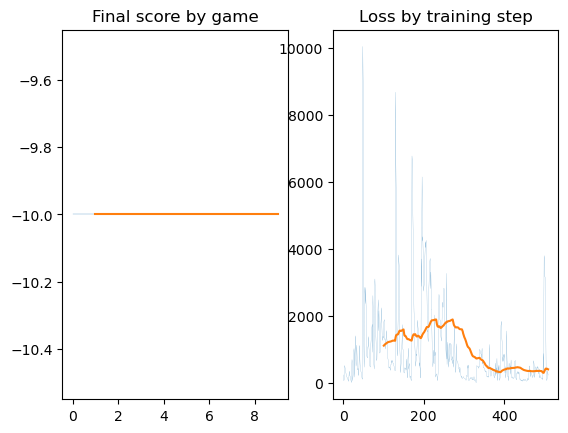

In [44]:
Q_learning(agent, stockfish, games_to_play=10, max_game_moves=50)


In [41]:
def choose_move(agent, board):
    
    if agent == 'random':
        chosen_move = random.choice(list(board.legal_moves))
    
    else:
        bit_state = agent.convert_state(board)
        valid_moves_tensor, valid_move_dict = agent.mask_and_valid_moves(board)

        with torch.no_grad():
            tensor = torch.from_numpy(bit_state).float().unsqueeze(0)
            policy_values = agent.policy_net(tensor, valid_moves_tensor)
            chosen_move_index = int(policy_values.max(1)[1].view(1, 1))
            
            if chosen_move_index not in valid_move_dict:
                chosen_move = random.choice(list(board.legal_moves))
            else:
                chosen_move = valid_move_dict[chosen_move_index]
                
    return chosen_move


def test(agent, games=1, board_config=None):

    outcomes = []
    for game in range(games):
        
        done = False
        
        # Create a new standard board
        if board_config is None:
            board = chess.Board()
        
        # Create a board with the desired configuration (pieces and starting positions)
        else:
            board = chess.Board(board_config)
        
        game_moves = 0
        while not done:
            game_moves += 1
            
            # white moves
            if game_moves % 2 != 0:
                board.push(choose_move(agent, board))
            
            # black moves
            else:
                board.push(choose_move("random", board))
                
            done = board.result(claim_draw=True) != '*'

        outcomes.append(board.result(claim_draw=True))

    outcome_dict = {"1-0":"White won", "1/2-1/2":"Draw", "0-1":"Black won"}
    for o in set(outcomes):
        print(f"{o} {outcome_dict[o]}: {round(outcomes.count(o)/len(outcomes)*100)}%")

In [42]:
test(agent, games=20)


1-0 White won: 5%
0-1 Black won: 10%
1/2-1/2 Draw: 85%


In [43]:
test(ChessAgent(input_model_path="pretrained-agent-2000"), games=20)

1-0 White won: 5%
0-1 Black won: 15%
1/2-1/2 Draw: 80%
